In [23]:
!pip -q install torchmetrics

import os, shutil
from collections import Counter, OrderedDict

from google.colab import drive
import kagglehub

from xml.etree import ElementTree as ET

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import functional as T

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

from torchmetrics.detection.mean_ap import MeanAveragePrecision

import numpy as np
import matplotlib.pyplot as plt

import cv2

import PIL

from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.4 MB/s eta 0:00:00


In [ ]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu")
device

device(type='cuda')

In [ ]:
drive.mount('/content/drive')

path = kagglehub.dataset_download("huseyingunduz/diatom-dataset")

drive_path = '/content/drive/MyDrive/diatom-dataset'
shutil.copytree(path, drive_path)

Mounted at /content/drive


100%|██████████| 8.71G/8.71G [06:54<00:00, 22.6MB/s]

Extracting files...


'/content/drive/MyDrive/diatom-dataset'

In [ ]:
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/diatom-dataset'

Mounted at /content/drive


In [ ]:
diatom_dataset_root_dir = drive_path

diatom_images_dir = os.path.join(diatom_dataset_root_dir, "images")
diatom_xmls_dir = os.path.join(diatom_dataset_root_dir, "xmls")

In [ ]:
def parse_xml(filename):
  tree = ET.parse(os.path.join(diatom_xmls_dir, filename))
  root = tree.getroot()

  filename = root.find("filename").text + ".png"

  width = int(root.find("size/width").text)
  height = int(root.find("size/height").text)

  objs = []

  for obj in root.findall("objects/object"):
    class_id = int(obj.find("id").text)
    class_name = obj.find("name").text

    xmin = int(obj.find("bbox/xmin").text)
    xmax = int(obj.find("bbox/xmax").text)
    ymin = int(obj.find("bbox/ymin").text)
    ymax = int(obj.find("bbox/ymax").text)

    objs.append({
      "class_id": class_id,
      "class_name": class_name,
      "xmin": xmin,
      "xmax": xmax,
      "ymin": ymin,
      "ymax": ymax,
    })

  return {
    "filename": filename,
    "width": width,
    "height": height,
    "objects": objs
  }

parse_xml("25.xml")

{'filename': '25.png',
 'width': 2112,
 'height': 1584,
 'objects': [{'class_id': 142,
   'class_name': 'Gomphonema drutelingense',
   'xmin': 604,
   'xmax': 874,
   'ymin': 1101,
   'ymax': 1248},
  {'class_id': 1,
   'class_name': 'Cymbella cantonatii',
   'xmin': 648,
   'xmax': 1227,
   'ymin': 839,
   'ymax': 1116}]}

In [ ]:
class DiatomDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform

    self.xml_dir = os.path.join(self.root_dir, "xmls")
    self.image_dir = os.path.join(self.root_dir, "images")

    self.xml_files = os.listdir(self.xml_dir)
    self.xmls = [parse_xml(xml_file) for xml_file in self.xml_files]
    self.xmls = [xml for xml in self.xmls if len(xml["objects"]) > 0]

    class_counter = Counter(obj["class_name"] for xml in self.xmls for obj in xml["objects"])

    sorted_items = sorted(class_counter.items(), key=lambda x: x[1], reverse=True)

    self.class_to_idx = {class_name: i + 1 for i, (class_name, _) in enumerate(sorted_items)}
    self.classes = {class_id: class_name for class_name, class_id in self.class_to_idx.items()}

  def __len__(self):
    return len(self.xmls)

  def __getitem__(self, index):
    xml = self.xmls[index]

    image_filename = os.path.join(self.image_dir, xml["filename"])

    image = PIL.Image.open(image_filename).convert("RGB")
    if self.transform:
      image = self.transform(image)

    boxes, labels = zip(*[
      (
        (*self._extract_bndbox(obj),), self.class_to_idx[obj["class_name"]]
      ) for obj in xml["objects"]
    ])

    target = {
      "boxes": torch.tensor(boxes, dtype=torch.float32),
      "labels": torch.tensor(labels, dtype=torch.int64),
    }

    return image, target

  def _extract_bndbox(self, obj):
    return obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]

In [ ]:
diatom_dataset = DiatomDataset(diatom_dataset_root_dir)

image, target = diatom_dataset[0]
image.size, target

((2112, 1584),
 {'boxes': tensor([[1318.,  318., 1437.,  866.]]), 'labels': tensor([2])})

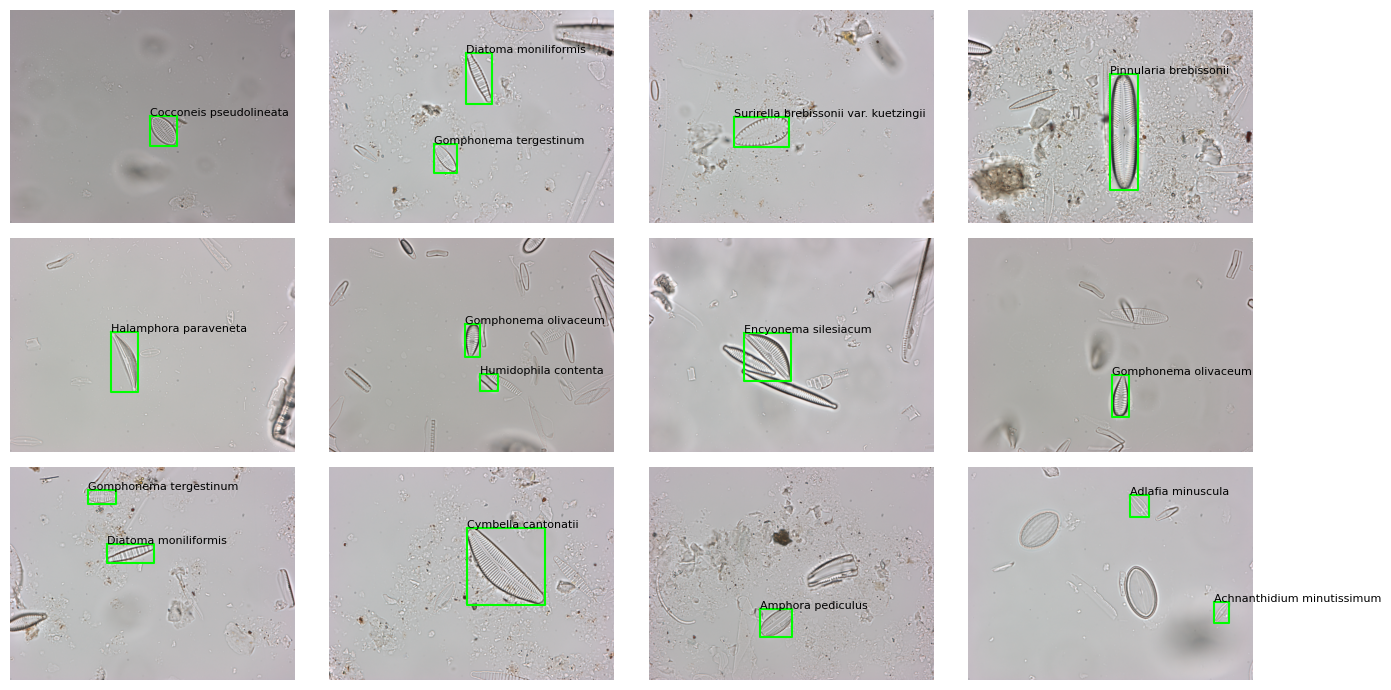

In [ ]:
def plot_random_samples(dataset, n_rows=3, n_cols=4):
  n_samples = n_rows * n_cols

  sample_indices = np.random.choice(len(dataset), n_samples)

  plt.figure(figsize=(14, 7))

  for i in range(n_samples):
    image, target = dataset[sample_indices[i]]
    labels = [dataset.classes[label.cpu().item()] for label in target["labels"]]

    plt.subplot(n_rows, n_cols, i + 1)

    plt.imshow(image)
    plt.axis(False)

    for j, box in enumerate(target["boxes"]):
      xmin, ymin, xmax, ymax = box.cpu().numpy()

      plt.plot(
        [xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        color="lime"
      )
      plt.text(xmin, ymin, labels[j], color="black", fontsize=8)


  plt.tight_layout()
  plt.show()

plot_random_samples(diatom_dataset)

In [ ]:
class_counter = Counter(label.cpu().item() for _, target in tqdm(diatom_dataset) for label in target["labels"])

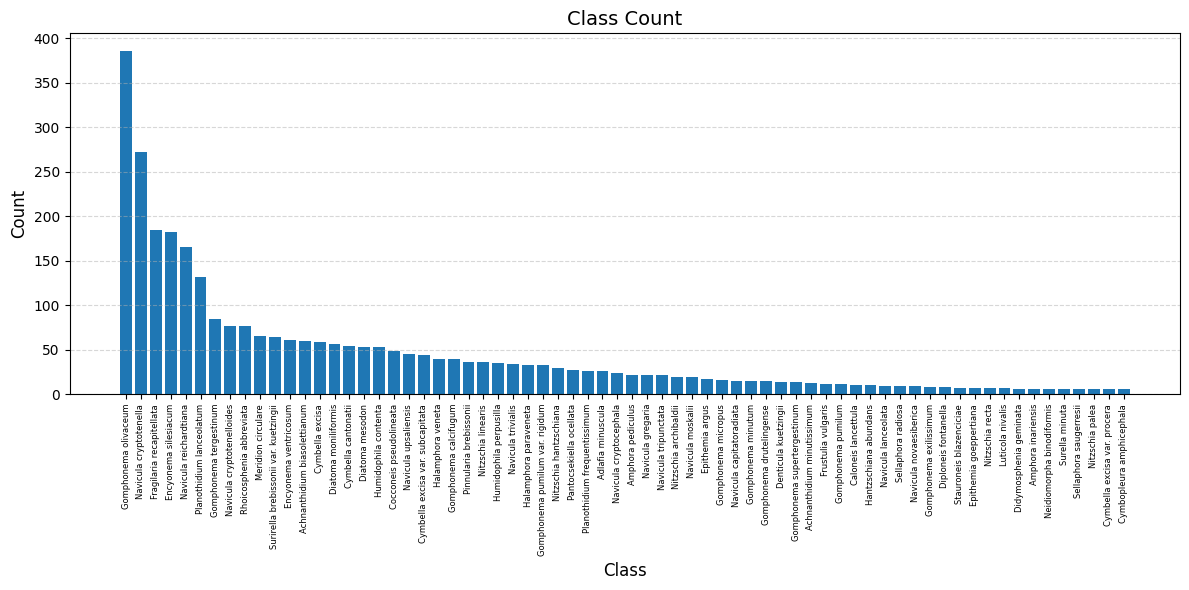

In [ ]:
sorted_items = sorted(class_counter.items(), key=lambda x: x[1], reverse=True)
sorted_keys, sorted_values = zip(*sorted_items)

plt.figure(figsize=(12, 6))
plt.bar(sorted_keys, sorted_values)

plt.title("Class Count", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

xticks = range(1, len(sorted_keys)+1)
xtick_labels = [diatom_dataset.classes[x] for x in xticks]

plt.xticks(xticks, xtick_labels, rotation=90, fontsize=6)

plt.tight_layout()
plt.show()

In [ ]:
diatom_dataset = DiatomDataset(
  root_dir=diatom_dataset_root_dir,
  transform=transforms.ToTensor()
)

diatom_dataloader = DataLoader(
  dataset=diatom_dataset,
  batch_size=2,
  shuffle=True,
  collate_fn=lambda batch: tuple(zip(*batch))
)

classes = diatom_dataset.classes

In [ ]:
def get_model(n_classes):
  weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
  model = fasterrcnn_resnet50_fpn(weights=weights)

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

  return model

In [ ]:
model = get_model(len(classes) + 1).to(device)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
model.train()

with torch.no_grad():
  images, targets = next(iter(diatom_dataloader))

  images = tuple(image.to(device) for image in images)
  targets = tuple({k: v.to(device) for k, v in target.items()} for target in targets)

  print(type(images), type(targets))
  print(images[0], targets[0])

  loss_dict = model(images, targets)
  print(loss_dict)

<class 'tuple'> <class 'tuple'>
tensor([[[0.6784, 0.6784, 0.6824,  ..., 0.6784, 0.6745, 0.6784],
         [0.6824, 0.6824, 0.6863,  ..., 0.6745, 0.6745, 0.6745],
         [0.6902, 0.6902, 0.6902,  ..., 0.6706, 0.6706, 0.6706],
         ...,
         [0.6588, 0.6588, 0.6510,  ..., 0.6784, 0.6784, 0.6784],
         [0.6667, 0.6667, 0.6588,  ..., 0.6784, 0.6784, 0.6745],
         [0.6745, 0.6745, 0.6667,  ..., 0.6784, 0.6784, 0.6745]],

        [[0.6784, 0.6784, 0.6784,  ..., 0.6784, 0.6784, 0.6784],
         [0.6784, 0.6784, 0.6784,  ..., 0.6784, 0.6784, 0.6784],
         [0.6784, 0.6784, 0.6824,  ..., 0.6784, 0.6784, 0.6784],
         ...,
         [0.6510, 0.6471, 0.6392,  ..., 0.6588, 0.6588, 0.6588],
         [0.6588, 0.6549, 0.6471,  ..., 0.6588, 0.6588, 0.6588],
         [0.6588, 0.6588, 0.6549,  ..., 0.6588, 0.6588, 0.6588]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.6824, 0.6824, 0.6824],
         [0.6941, 0.6941, 0.6941,  ..., 0.6824, 0.6824, 0.6824],
         [0.6941, 0.6941, 

In [ ]:
model.eval()

with torch.no_grad():
  images, _ = next(iter(diatom_dataloader))

  images = tuple(image.to(device) for image in images)

  outputs = model(images)
  print(outputs)

[{'boxes': tensor([[0.0000e+00, 4.3560e+02, 8.0335e+01, 6.8154e+02],
        [7.9342e+02, 2.0422e+02, 9.0330e+02, 3.4677e+02],
        [5.4890e+00, 3.6970e+02, 1.1276e+02, 4.8067e+02],
        [5.7729e+01, 1.2175e+03, 6.5014e+02, 1.5840e+03],
        [3.9601e+00, 5.1432e+02, 1.0096e+02, 6.5215e+02],
        [6.9999e+01, 9.8179e+02, 1.0142e+03, 1.5840e+03],
        [6.9165e+02, 1.3354e+03, 1.1425e+03, 1.4580e+03],
        [2.5075e+00, 4.0258e+02, 6.0035e+01, 6.0924e+02],
        [1.9343e+03, 1.6255e+02, 1.9526e+03, 1.7824e+02],
        [1.3734e+02, 6.6158e+02, 6.2067e+02, 1.5160e+03],
        [1.8854e+01, 4.5864e+02, 1.2724e+02, 6.7548e+02],
        [2.3431e-01, 5.8344e+02, 8.5097e+01, 6.9302e+02],
        [1.4024e+03, 8.0964e+01, 1.4596e+03, 1.5075e+02],
        [1.4424e+00, 4.8072e+01, 3.0537e+02, 6.2365e+02],
        [1.5337e+03, 1.5429e+03, 1.7881e+03, 1.5840e+03],
        [2.6729e+01, 9.9140e+02, 4.3378e+02, 1.5840e+03],
        [1.9319e+03, 1.5837e+02, 1.9585e+03, 1.7616e+02],
   

In [19]:
# 23:40 - 00:55

n_epochs = 5

optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.005, momentum=0.9)

for epoch in range(1, n_epochs + 1):
  model.train()

  for images, targets in tqdm(diatom_dataloader, desc="Training"):
    images = tuple(image.to(device) for image in images)
    targets = tuple({k: v.to(device) for k, v in target.items()} for target in targets)

    loss_dict = model(images, targets)
    loss = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.2363


Epoch 2 | Loss: 0.0682


Epoch 3 | Loss: 0.1126


Epoch 4 | Loss: 0.1074


Epoch 5 | Loss: 0.1249


In [21]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": 5
    },
    "/content/drive/MyDrive/model/fasterrcnn_resnet50_fpn_diatom_250428.pth"
)

In [28]:
metric = MeanAveragePrecision().to(device)

model.eval()

with torch.no_grad():
  for images, targets in tqdm(diatom_dataloader, desc="Evaluating"):
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    outputs = model(images)

    metric.update(outputs, targets)

final_score = metric.compute()

print(final_score)

{'map': tensor(0.6558), 'map_50': tensor(0.8401), 'map_75': tensor(0.8181), 'map_small': tensor(-1.), 'map_medium': tensor(0.6003), 'map_large': tensor(0.6557), 'mar_1': tensor(0.7435), 'mar_10': tensor(0.7809), 'mar_100': tensor(0.7809), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.6000), 'mar_large': tensor(0.7811), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68],
       dtype=torch.int32)}
